In [15]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import plotly.figure_factory as ff
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

train = pd.read_csv("history_final.csv")
#latest_dates = train.groupby('Symbol')['Date'].max().reset_index()

#filtered_stock_data = pd.merge(train, latest_dates, on=['Symbol', 'Date'], how='outer')
#train = filtered_stock_data.copy()


#### Prepare training and test sets
First we encode the label column with 1 for up and 0 for down then We drop the Label column for the test set.

We drop the Date column because dates of past stock prices are not relevant to predicting a new stock price movement TODAY. Dates may also create a bias during testing of the model because the price movement of stocks on a given day is often correlated - so if we're testing the model and input a stock price on day x, and the model learned that other stocks on day x generally moved up, that would influence the prediction. That would be bad because when we predict stock prices for real we don't know other stock price movements for that day yet.

Before using the decision tree classifier we need to make additional modifications to the training data set. In scikit specifically, tree classifiers only operate on numeric features. We drop the Symbol column because it is not numeric. One-hot encoding each symbol (~500 symbols) would be too specific. We one-hot encode the Sector column; this one is a good candidate for one-hot encoding.

We'll also encode two date features, the month 1-12 and the day of the week 0-6 where monday = 0 and sunday = 6 

We have one training set where we drop the Volume column, and one where we drop the VolumeScaledNormalized column. Then we compare the performance of the model.

We'll also compare including the sector column and not including it to look for sector correlations.



Our first run will be using normalized data for the volume
 Mapping sector to numeric values:
 0 -> Industrials
 1 -> Health Care
 2 -> Information Technology
 3 -> Consumer Discretionary
 4 -> Financials
 5 -> Materials
 6 -> Real Estate
 7 -> Consumer Staples
 8 -> Energy
 9 -> Utilities
 10 -> Telecommunication Services

In [16]:


train['day_of_week'] = pd.to_datetime(train['Date']).dt.dayofweek
train['month'] = pd.to_datetime(train['Date']).dt.month

train['Sector'] = train['Sector'].map(
    {'Industrials': 0, 'Health Care': 1, 'Information Technology': 2, 'Consumer Discretionary': 3, 'Financials': 4,
     'Materials': 5, 'Real Estate': 6, 'Consumer Staples': 7, 'Energy': 8, 'Utilities': 9,
     'Telecommunication Services': 10})
final_df = train.copy()

Looking at the heat map we'll clearly need to drop certain features including: Open, High, Low, CloseDif since these giveaway
whether the stock goes up or down.

First run we'll drop volume and used the normalised volume 


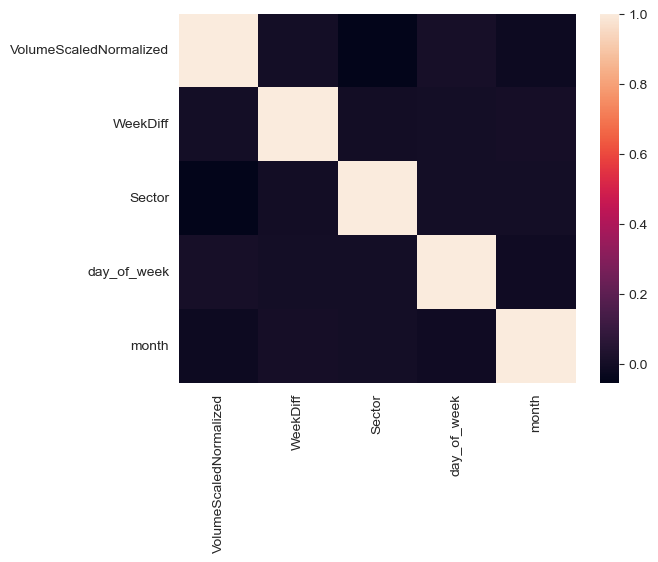

In [17]:
y = train['Label']
# train.drop(['Label','Date'], axis=1, inplace=True)
# train = train.drop('Symbol', axis=1)
# 
# #create a correlation heatmap to see which features are correlated with each other
# 
# 
# train_norm = train.drop(['Volume'], axis=1)
# train_norm.drop(['Open', 'Low', 'High', 'CloseDiff', 'Close'], axis=1, inplace=True)
train.drop(['Label', 'Date', 'Symbol', 'Open', 'Low', 'High', 'CloseDiff', 'Close', 'Volume'], axis=1, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=123)

Random Forest Classifier: We chose random as first option as its known to be good at handling large amounts of data and less pron to overfitting

0.540520865793789
0.7017378054341031


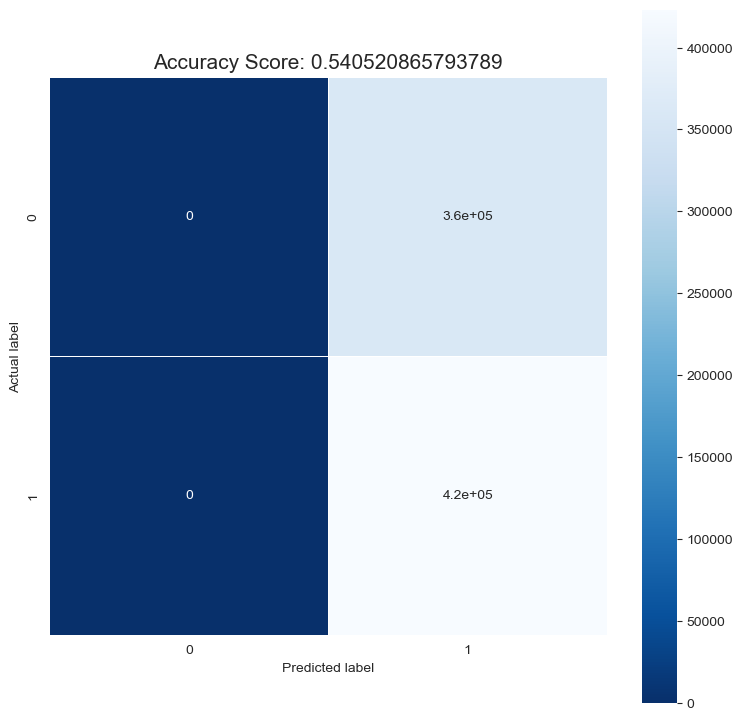

In [18]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

rf_acc_nv = metrics.accuracy_score(y_test, pred)
rf_f1_nv = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()






0.5445540508094467
0.6721827457829664


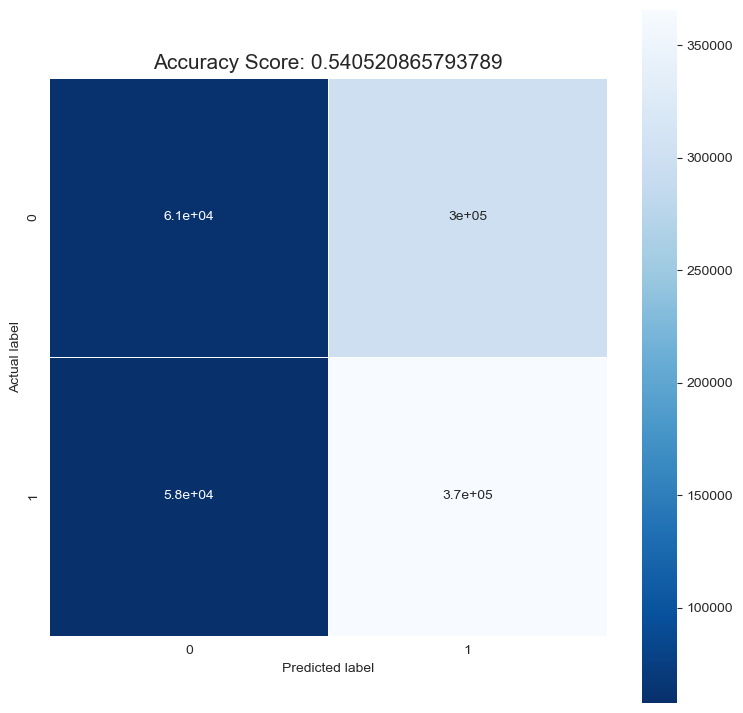

In [19]:
dt = DecisionTreeClassifier(max_depth=10, random_state=0)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

dt_acc_nv = metrics.accuracy_score(y_test, pred)
dt_f1_nv = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()

0.5483547976766402
0.6749715999955883


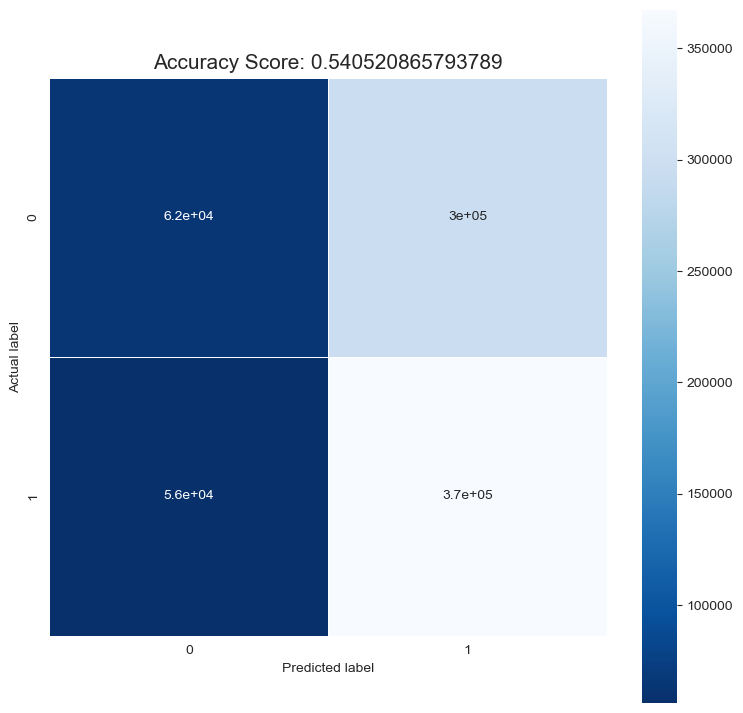

In [20]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)

xgb_acc_nv = metrics.accuracy_score(y_test, pred)
xgb_f1_nv = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()

Next run we'll use the regular volume and drop the normalised volume

In [21]:
train = final_df.copy()
y = train['Label']
# train.drop(['Label','Date'], axis=1, inplace=True)
# train = train.drop('Symbol', axis=1)
# train_norm = train.drop(['VolumeScaledNormalized'], axis=1)
# train_norm.drop(['Open', 'Low', 'High', 'CloseDiff'], axis=1, inplace=True)

train.drop(['Label', 'Date', 'Symbol', 'Open', 'Low', 'High', 'CloseDiff', 'Close', 'VolumeScaledNormalized'], axis=1,
           inplace=True)
train.to_csv('encoded_df.csv', index=False)

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=123)

0.540520865793789
0.7017378054341031


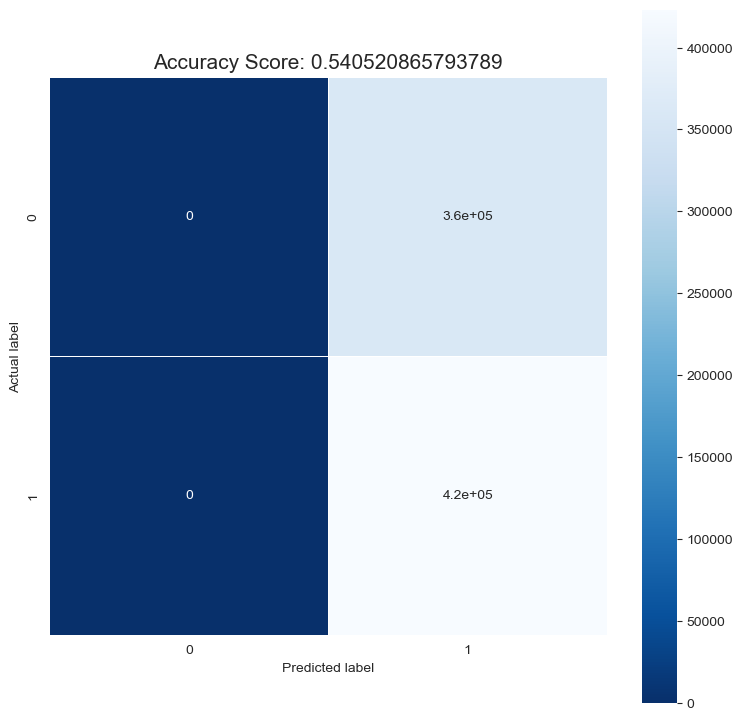

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

rf_acc_v = metrics.accuracy_score(y_test, pred)
rf_f1_v = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()

0.5445553279421306
0.6721839663703945


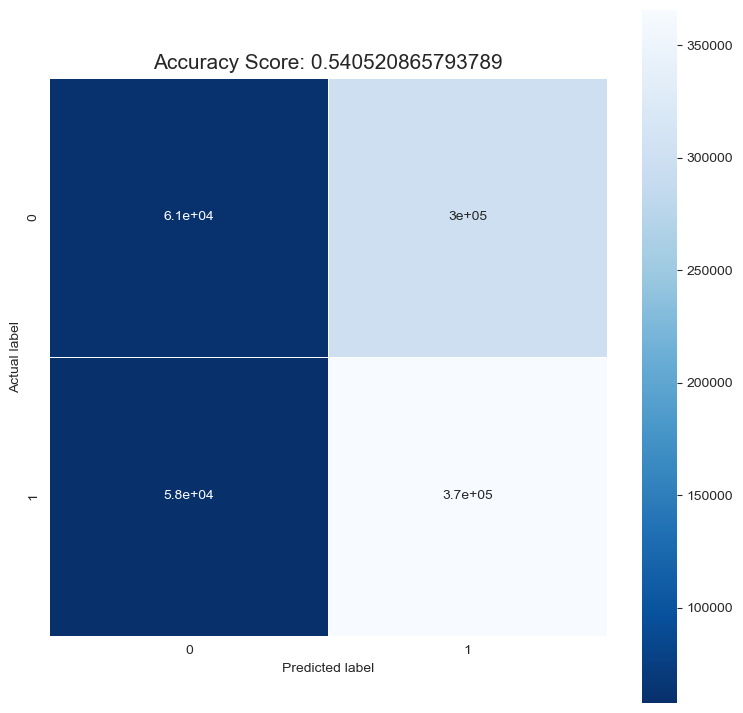

In [23]:
dt = DecisionTreeClassifier(max_depth=10, random_state=0)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

dt_acc_v = metrics.accuracy_score(y_test, pred)
dt_f1_v = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()

[1 1 1 ... 1 1 0]
891128     1
1137204    0
102839     0
2410986    0
3311261    1
          ..
1333182    1
2985609    1
3066606    1
435038     1
3534764    0
Name: Label, Length: 783004, dtype: int64
0.5478043534898928
0.6745003801330604


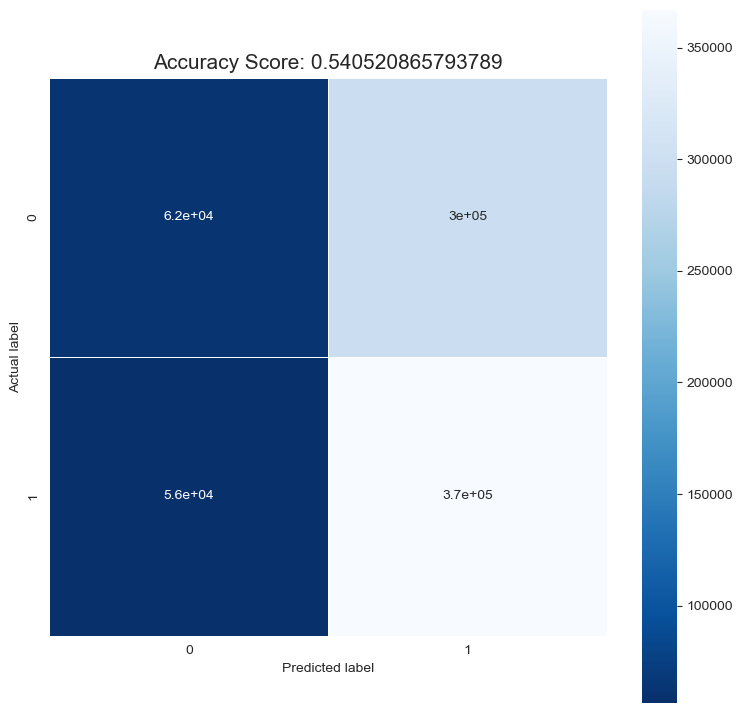

In [24]:
import xgboost as xgb
import plotly.graph_objs as go
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)
print(pred)
print(y_test)

xgb_acc_v = metrics.accuracy_score(y_test, pred)
xgb_f1_v = metrics.f1_score(y_test, pred)

print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

confusion = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9, 9))
sns.heatmap(confusion, annot=True, linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc_nv)
plt.title(all_sample_title, size=15);
plt.show()

labels = ['Down', 'Up']
fig = ff.create_annotated_heatmap(
    z=confusion,
    x=labels,
    y=labels,
    colorscale='Blues',
)
fig.update_layout(
    title='Confusion Matrix - Stock Price Movement Prediction',
    xaxis=dict(title='Predicted', side='bottom'),
    yaxis=dict(title='Actual'),
)
fig.layout.template = 'ggplot2'
fig.show()

fpr, tpr, _ = roc_curve(y_test, pred)

fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='blue', width=2), name='ROC Curve'))

fig1.add_shape(type='line', line=dict(color='gray', width=1, dash='dash'),
               x0=0, y0=0, x1=1, y1=1)

fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title='ROC Curve',
    showlegend=True,
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    width=600,
    height=400,
    margin=dict(l=50, r=50, t=50, b=50),
)
fig1.layout.template = 'ggplot2'
fig1.show()

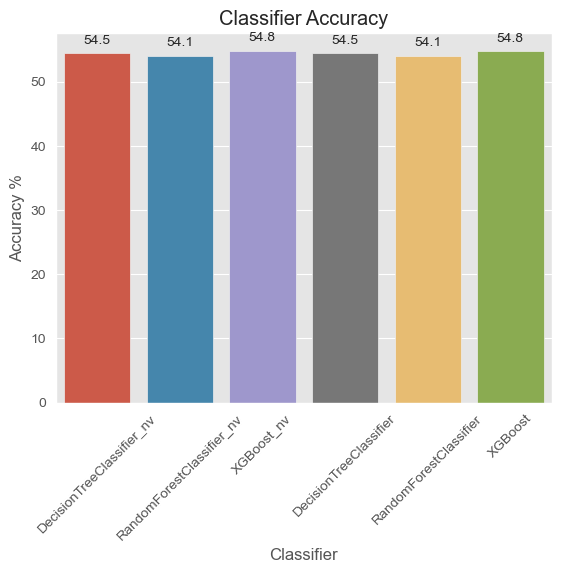

In [25]:
plt.style.use('ggplot')
data = {'Classifier': ["DecisionTreeClassifier_nv", "RandomForestClassifier_nv", "XGBoost_nv", "DecisionTreeClassifier",
                       "RandomForestClassifier", "XGBoost"],
        'Acc': [dt_acc_nv, rf_acc_nv, xgb_acc_nv, dt_acc_v, rf_acc_v, xgb_acc_v], }
for count, el in enumerate(data['Acc']):
    data['Acc'][count] = el * 100
acc_data = pd.DataFrame(data, columns=['Classifier', 'Acc'])
g = sns.barplot(x='Classifier', y='Acc', data=acc_data)
plt.xticks(rotation=45)
plt.ylabel('Accuracy %')
plt.title('Classifier Accuracy')
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
               va='center', xytext=(0, 9), textcoords='offset points')
plt.show()



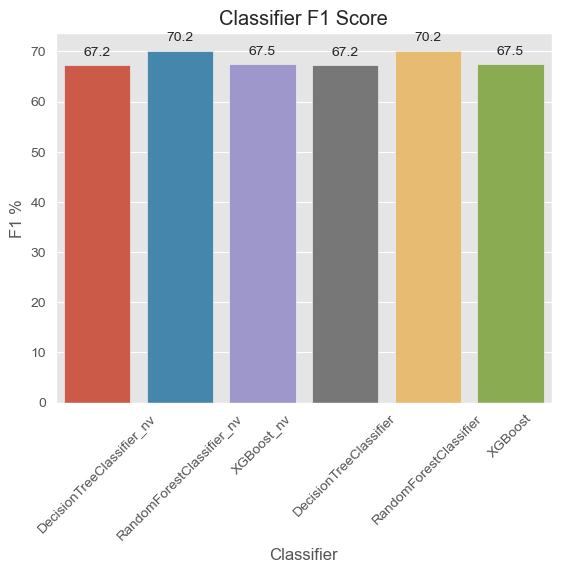

In [26]:
plt.style.use('ggplot')
data = {'Classifier': ["DecisionTreeClassifier_nv", "RandomForestClassifier_nv", "XGBoost_nv", "DecisionTreeClassifier",
                       "RandomForestClassifier", "XGBoost"],
        'F1': [dt_f1_nv, rf_f1_nv, xgb_f1_nv, dt_f1_v, rf_f1_v, xgb_f1_v], }
for count, el in enumerate(data['F1']):
    data['F1'][count] = el * 100
F1_data = pd.DataFrame(data, columns=['Classifier', 'F1'])
g = sns.barplot(x='Classifier', y='F1', data=F1_data)
plt.xticks(rotation=45)
plt.ylabel('F1 %')
plt.title('Classifier F1 Score')
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
               va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

main_df = pd.read_csv('history_final.csv')

main_df['day_of_week'] = pd.to_datetime(main_df['Date']).dt.dayofweek
main_df['month'] = pd.to_datetime(main_df['Date']).dt.month
main_df['Sector'] = main_df['Sector'].map(
    {'Industrials': 0, 'Health Care': 1, 'Information Technology': 2, 'Consumer Discretionary': 3, 'Financials': 4,
     'Materials': 5, 'Real Estate': 6, 'Consumer Staples': 7, 'Energy': 8, 'Utilities': 9,
     'Telecommunication Services': 10})
encoded_df = pd.read_csv('encoded_df.csv')

y = main_df['Label']

names = main_df['Symbol'].unique()

X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2, random_state=123)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

test_df = main_df[main_df['Symbol'] == 'GOOG']
testy_df = test_df.drop(
    ['Label', 'Date', 'Open', 'Close', 'CloseDiff', 'Symbol', 'VolumeScaledNormalized', 'Low', 'High'], axis=1)

tester = test_df['Label']

pred = xgb_model.predict(testy_df)
print(pred)
conf_matrix = confusion_matrix(tester, pred)

labels = ['Down', 'Up']
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=labels,
    y=labels,
    colorscale='Blues',
)
fig.update_layout(
    title='Confusion Matrix - Stock Price Movement Prediction',
    xaxis=dict(title='Predicted', side='bottom'),
    yaxis=dict(title='Actual'),
)
fig.show()

[0 1 0 ... 0 0 0]


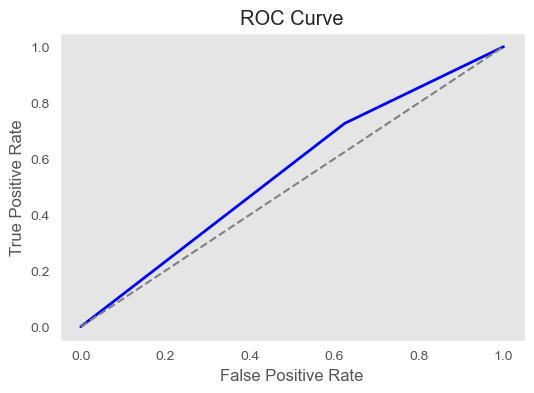

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(tester, pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()  # Close the plot to avoid displaying it immediately


In [29]:
# Assuming you already have values for tester and pred from your model
import plotly.graph_objs as go
fpr, tpr, _ = roc_curve(tester, pred)

# Create a Plotly figure for the ROC curve
fig = go.Figure()

# Add the ROC curve trace
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='blue', width=2), name='ROC Curve'))

# Add the diagonal reference line
fig.add_shape(type='line', line=dict(color='gray', width=1, dash='dash'),
              x0=0, y0=0, x1=1, y1=1)

# Update layout
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title='ROC Curve',
    showlegend=True,
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    width=600,
    height=400,
    margin=dict(l=50, r=50, t=50, b=50),
)

# Show the plot
fig.show()